In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some Reference
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt
http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_std_04,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,163.73709,29.010676,594.972659,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.00000,0.000000,0.000000,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.00000,0.000000,0.000000,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.00000,0.000000,0.000000,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.00000,0.000000,0.000000,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
#dataset.columns.values

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
temp --> 5326
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 665)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 665)

# Target definition

In [7]:
target = 'VALTOT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [8]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

4.11248507928211

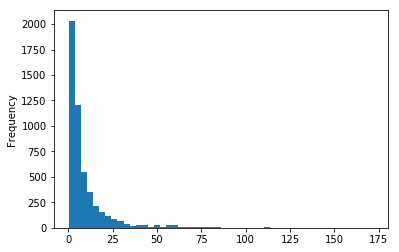

In [9]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [10]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [11]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
#dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

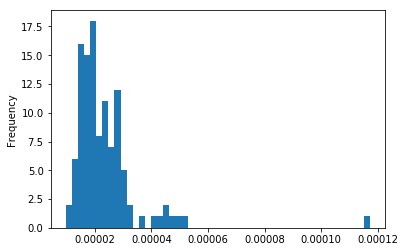

In [12]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [13]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [14]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 666)

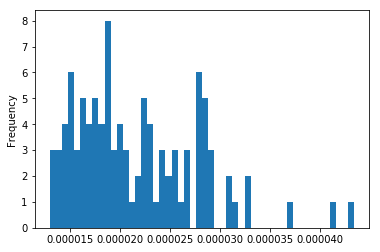

In [15]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [16]:
skew(dataset[target])

3.8603967850964476

# Outlier tracking - VALAJOUT

In [17]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [18]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

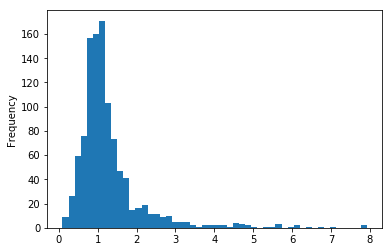

In [19]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [20]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.704800
                     0.95          7.743000
          1          0.02          0.515800
                     0.95          2.330000
          2          0.02          0.245067
                     0.95          2.154667
          3          0.02          0.623350
                     0.95          1.954250
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.218000
                     0.95          5.710000
          1          0.02          0.393500
                     0.95          1.483750
          2          0.02          0.405467
                     0.95          1.916500
          3          0.02          0.363850
                     0.95          2.401375
...                                     ...
10.0      0          0.02          0.592000
                     0.95          9.260000
          1          0.02          0.968600
                     0.95          4.102000
          2          0.02          0.489067
                     0.95          3.470000
          3          0.02          0.990350
                     0.95          3.877875
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.860500
          1          0.02          0.165000
                     0.95          2.267500
          2          0.02          0.716667
                     0.95          1.723333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.737000
                     0.95          8.658000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.526667
          3          0.02          0.870000
                     0.95          1.151250

[148 rows x 1 columns]

In [21]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4316, 667)

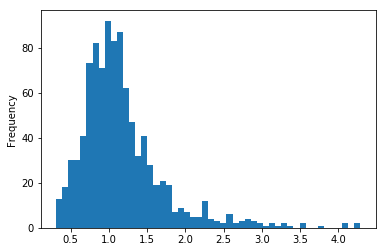

In [22]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [23]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VALTOT
count,4316.000000
mean,7.457875
std,8.850946
min,0.370000
25%,2.560000
50%,4.480000
75%,9.040000
max,136.740000


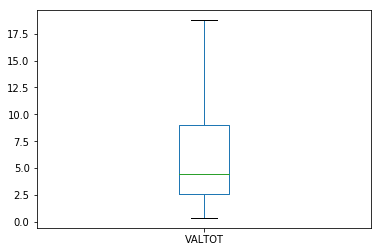

In [24]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [25]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',]

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

143


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bendlength_bend_radius_00',
 'bendlength_bend_angle_00',
 'bendlength_bend_direction_00',
 'bendlength_deformation_length_00',
 'bendlength_merged_bend_00',
 'bendlength_punch_length_00',
 'bendlength_bend_radius_01',
 'bendlength_bend_angle_01',
 'bendlength_bend_direction_01',
 'bendlength_deformation_length_01',
 'bendlength_merged_bend_01',
 'bendlength_punch_length_01',
 'bendlength_bend_radius_02',
 'bendlength_bend_angle_02',
 'bendlength_bend_direction_02',
 'bendlength_deformation_length_02',
 'bendlength_merged_bend_02',
 'bendlength_punch_length_02',
 'bendlength_bend_radius_03',
 'bendlength_bend_angle_03',
 'bendlength_bend_direction_03',
 'bendlength_deformation_length_03',
 'bendlength_merged_bend_03',
 'bendleng

In [26]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3021, 667) (1295, 667)


# Box_cox feature creation

In [27]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [28]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [29]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [30]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [31]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [32]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        #learning_rate=0.25,
                        n_estimators=200,
                        #max_depth=500,
                        #lambda_l1=0.1,
                        #min_child_samples=10,
                        random_state=0,
                       )

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [34]:
#Pipe definition
pipe = [('scaler', scaler), ('gbm', gbm)]

# Direct prediction

In [35]:
regpip = Pipeline(pipe)

In [36]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [37]:
param_grid = {
    'gbm__learning_rate': [0.125, 0.1, .075],
    #'gbm__n_estimators': [300, 400, 500],
    #'gbm__lambda_l1': np.logspace(-3,3,4),
    #'gbm__lambda_l2': np.logspace(-3,3,4),
    #'gbm__max_bin':[200, 150],
    'gbm__num_leaves':[20, 30, 40],
    'gbm__max_depth':[-1, 6,10],
    #'gbm__min_split_gain':[0,.1, 0.05],
    'gbm__min_data_in_leaf':[20,30,10],
    }

#MSE version
gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#MAPE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [38]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-3.985077850281661, total=   1.9s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-9.340555174318126, total=   2.2s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-11.741608157357794, total=   2.9s
[CV] gbm__learning_rate=0.125, gbm__max_depth=

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   13.9s


[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-4.192819483092563, total=   2.8s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-12.462796314860556, total=   3.4s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-12.8385970581129, total=   4.9s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-4.105438940319415, total=   3.1s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_

[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-6.115756623255575, total=   1.3s
[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-10.648050051732643, total=   1.6s
[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-3.476527008428071, total=   1.3s
[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-6.858647243267073, total=   1.1s
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=20,

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:   52.6s


[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-4.0771225658066905, total=   1.4s
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-12.274262032542708, total=   1.9s
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-12.671535907016883, total=   2.2s
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-12.772929757383144, total=   0.4s
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data

[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-3.552316114896004, total=   3.6s
[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-6.884395803732235, total=   4.1s
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-11.10381616291289, total=   5.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-11.20693621932444, total=   4.0s
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_

[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-11.92067804618616, total=   2.2s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-9.6117438096099, total=   2.2s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-4.016604050717707, total=   2.1s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40, score=-9.189423374966786, total=   1.7s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_lea

[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  2.1min


[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-11.137648523824819, total=   2.4s
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-6.773622108684182, total=   2.3s
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-3.979020048822449, total=   2.1s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-10.976019169331385, total=   1.2s
[CV] gbm__learning_rate=0.075, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__n

[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-3.9259123284768616, total=   1.3s
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-9.414556665197921, total=   1.2s
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-11.379626105934076, total=   1.7s
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-3.8520954394307085, total=   1.2s
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=2

[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=20, score=-12.552564036928874, total=   2.2s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-12.41630457547202, total=   1.5s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-3.885203527157013, total=   1.8s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-12.742320944835434, total=   2.5s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in

[Parallel(n_jobs=-2)]: Done 243 out of 243 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__learning_rate': [0.125, 0.1, 0.075], 'gbm__num_leaves': [20, 30, 40], 'gbm__max_depth': [-1, 6, 10], 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [39]:
target

'VALTOT'

In [40]:
gridgbm.best_params_

{'gbm__learning_rate': 0.075,
 'gbm__max_depth': -1,
 'gbm__min_data_in_leaf': 10,
 'gbm__num_leaves': 20}

In [41]:
gridgbm.best_score_

-6.591855255592721

In [42]:
mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))

14.160510947954796

In [43]:
mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))

4.668854433510233

In [44]:
mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))

0.8442163041442697

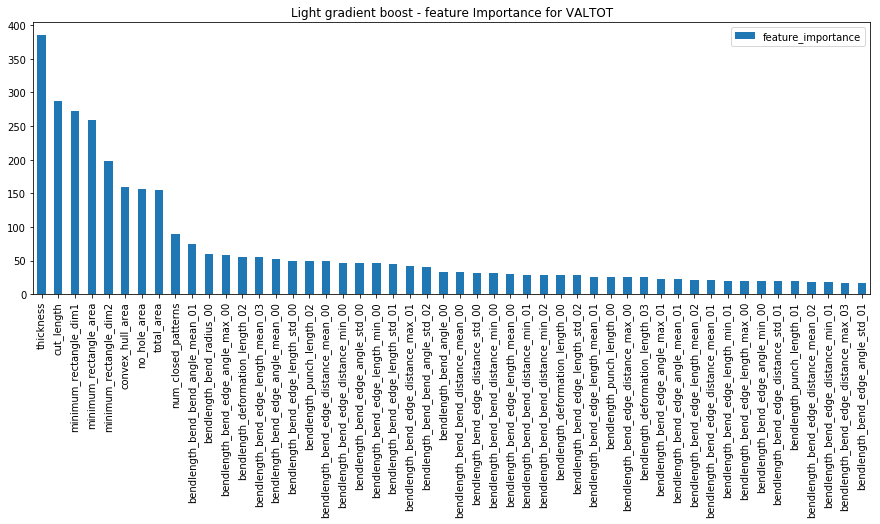

In [45]:
featimp = list(gridgbm.best_estimator_.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [46]:
regpiplog = Pipeline(pipe)

In [47]:
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [48]:
param_grid = {
    'gbm__learning_rate': [0.125, 0.1, .075],
    #'gbm__n_estimators': [300, 400, 500],
    #'gbm__lambda_l1': np.logspace(-3,3,4),
    #'gbm__lambda_l2': np.logspace(-3,3,4),
    #'gbm__max_bin':[200, 150],
    'gbm__num_leaves':[20, 30, 40],
    'gbm__max_depth':[-1, 6,10],
    #'gbm__min_split_gain':[0,.1, 0.05],
    'gbm__min_data_in_leaf':[20,30,10],
    }

#MSE version
gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=5)

#MAPE version
#gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [49]:
gridgbmlog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.11480563328690178, total=   1.2s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.11066602680012447, total=   2.5s
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.11131061450623103, total=   2.5s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV] gbm__learning_rate=0.125, gbm__max_d

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   14.3s


[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.11063003854176325, total=   2.5s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.11401165460014535, total=   4.1s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.11279557718926318, total=   3.4s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.11254264701795358, total=   3.2s
[CV] gbm__learning_rate=0.125, gbm__max_depth=-1, gbm__min_d

[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=20, score=-0.11181595274646372, total=   2.3s
[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.11343692461910186, total=   1.7s
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.10996115723364466, total=   2.2s
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.1122264378075967, total=   2.6s
[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=6, gbm__min_data_in_le

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:   58.3s


[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.11115248232586844, total=   2.0s
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.11413885616532407, total=   2.7s
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.112090176783177, total=   1.8s
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.11267255438857417, total=   1.8s
[CV] gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__learning_rate=0.125, gbm__max_depth=10, gbm__min_da

[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.11098234805119259, total=   2.5s
[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.11092336240376299, total=   3.2s
[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.11134745302021966, total=   4.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=-1, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.11092779577618697, total=   3.8s
[CV] gbm__learning_rate=0.1, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm

[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.11018924189153433, total=   2.5s
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.11147898968494319, total=   2.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.11217518330298804, total=   3.2s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=20, gbm__num_leaves=40, score=-0.1101015994394346, total=   2.3s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm

[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  2.3min


[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.11285670943358023, total=   3.3s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.11023413320301836, total=   2.2s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=30, score=-0.10947820163285431, total=   3.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.11180634343875998, total=   2.4s
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.11084522432491074, total=   3.1s
[CV] gbm__learning_rate=0.075, gb

[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.10987845734995898, total=   1.7s
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.11260654544473105, total=   1.5s
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.10991131136316316, total=   1.7s
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.11129924625890875, total=   2.4s
[CV] gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=6, gbm__min_data_in_l

[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=20, score=-0.11091620636891053, total=   1.8s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.1097688739583858, total=   1.8s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.10963570755062542, total=   2.4s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.11234776625022255, total=   2.9s
[CV] gbm__learning_rate=0.075, gbm__max_depth=10, gbm__min_da

[Parallel(n_jobs=-2)]: Done 243 out of 243 | elapsed:  3.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__learning_rate': [0.125, 0.1, 0.075], 'gbm__num_leaves': [20, 30, 40], 'gbm__max_depth': [-1, 6, 10], 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=5)

In [50]:
target

'VALTOT'

In [51]:
gridgbmlog.best_params_

{'gbm__learning_rate': 0.075,
 'gbm__max_depth': -1,
 'gbm__min_data_in_leaf': 20,
 'gbm__num_leaves': 40}

In [52]:
mean_absolute_percentage_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))

12.616835627995309

In [53]:
mean_squared_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))

4.287517511554704

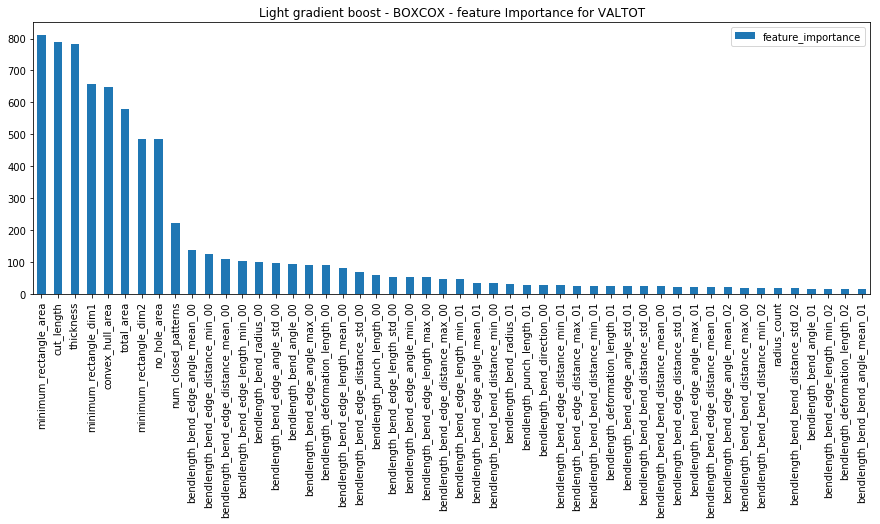

In [54]:
featimp = list(gridgbmlog.best_estimator_.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [55]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])
prediction_lgbm_log = inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda)

In [56]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                          'pred_lgbm_BOXCOX':prediction_lgbm_log,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target
COART,,,
L3104170,6.973162,6.977706,8.13
L8826140,2.499663,2.401807,2.42
L1615860,1.030293,0.822178,1.04
L8055440,4.188617,4.083776,4.55
L8042170,3.675951,3.580345,3.74


In [57]:
#Solution saving
resultset.to_csv(f'{target}_pred_lgbm.csv')


In [58]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mape', mape)
print('mapelog', mapelog)

mape 14.160510947954796
mapelog 12.616835627995309


In [59]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['pred_lgbm'])
mselog = mean_squared_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mse', mse)
print('mselog', mselog)

mse 4.668854433510233
mselog 4.287517511554704


In [60]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset['MSE_log_lgbm'] = (resultset['target']-resultset['pred_lgbm_BOXCOX'])**2
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm
COART,,,,,
L3104170,6.973162,6.977706,8.13,1.338274,1.327781
L8826140,2.499663,2.401807,2.42,0.006346,0.000331
L1615860,1.030293,0.822178,1.04,0.000094,0.047446
L8055440,4.188617,4.083776,4.55,0.130597,0.217365
L8042170,3.675951,3.580345,3.74,0.004102,0.025490


In [61]:
resultset['MSE_lgbm'].mean()

4.6688544335102335

In [62]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,...,bendlength_bend_edge_length_max_04,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L3104170,6.973162,6.977706,8.13,1.338274,1.327781,1986.643677,10,0,61139.761719,...,0.0,4.41,3.72,8.13,0.000011,0.000008,0.000014,0,0.000070,3.720
1,L8826140,2.499663,2.401807,2.42,0.006346,0.000331,496.880127,3,0,12029.566406,...,0.0,0.44,1.98,2.42,0.000006,0.000006,0.000006,1-2,0.000036,0.990
2,L1615860,1.030293,0.822178,1.04,0.000094,0.047446,391.016144,2,0,4399.901855,...,0.0,0.24,0.80,1.04,0.000009,0.000007,0.000009,0,0.000044,0.800
3,L8055440,4.188617,4.083776,4.55,0.130597,0.217365,776.781677,2,0,24182.181641,...,0.0,2.00,2.55,4.55,0.000008,0.000006,0.000008,1-2,0.000079,1.275
4,L8042170,3.675951,3.580345,3.74,0.004102,0.025490,858.618835,2,0,27643.671875,...,0.0,2.06,1.68,3.74,0.000012,0.000010,0.000012,1-2,0.000074,0.840


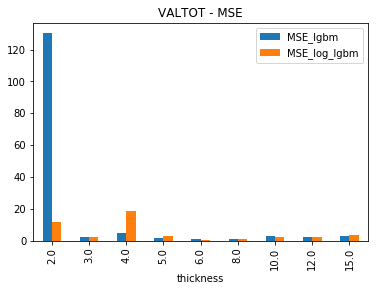

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
thickness,,,
2.0,130.177983,11.577535,26
3.0,2.475147,2.500404,106
4.0,4.734558,18.538176,187
5.0,1.594278,2.642766,142
6.0,0.904781,0.659606,299
8.0,0.830758,0.843526,243
10.0,3.134636,2.293670,149
12.0,2.172656,2.298442,91


In [63]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

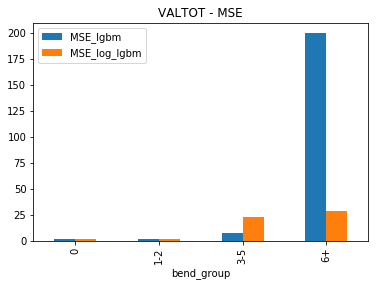

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
bend_group,,,
0,1.146615,1.167588,535
1-2,1.340653,1.109832,579
3-5,7.673362,23.178526,164
6+,199.885764,28.459085,17


In [64]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

In [65]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm_BOXCOX']), axis=1)

comparisonset[['target', 'pred_lgbm', 'MAPE_error', 'pred_lgbm_BOXCOX', 'MAPE_log_error']].head()

,target,pred_lgbm,MAPE_error,pred_lgbm_BOXCOX,MAPE_log_error
0,8.13,6.973162,14.229251,6.977706,14.173357
1,2.42,2.499663,3.291849,2.401807,0.751757
2,1.04,1.030293,0.933331,0.822178,20.944419
3,4.55,4.188617,7.942473,4.083776,10.246674
4,3.74,3.675951,1.712543,3.580345,4.268840


In [66]:
#MAPE
comparisonset['MAPE_error'].mean()

14.160510947954785

In [67]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

df.agg({'MSE_lgbm': ['mean', 'max'],
        'MSE_log_lgbm': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })

MSE_lgbm              MSE_log_lgbm               \
                            mean          max         mean          max   
thickness bend_group                                                      
2.0       1-2           0.337103     0.873071     0.218747     0.925787   
          3-5           5.577316    42.412547     2.848109    17.639833   
          6+          554.247228  3130.018997    45.057890   210.960871   
3.0       0             0.356584     1.403451     0.408917     1.386095   
          1-2           0.268539     1.237639     0.307557     1.378459   
          3-5           5.729256    69.909779     5.412123   153.956281   
          6+            9.024903    27.182161    11.818061    28.761977   
4.0       0             0.862853    16.721077     0.682348     5.563021   
          1-2           0.607164    17.100760     0.595166    23.394034   
          3-5          19.936935   367.674999    86.296815  3070.463186   
          6+            3.696577     5.621210     3.933285    10.502614   
5.0       0             0.270450     2.909424     0.261723     2.995988   
          1-2           2.093759   119.120037     2.024059    60.404084   
          3-5           2.139201    11.248048     3.647856    37.554148   
          6+            6.759342    20.270640    49.717928   148.623160   
6.0       0             0.434535    10.746718     0.342107    16.155022   
          1-2           0.649247     7.374102     0.392736     4.528424   
          3-5           3.243685    65.448533     2.571823    46.498311   
          6+            5.107260     5.107260     5.231219     5.231219   
8.0       0             0.695859    13.375387     0.493667     8.450853   
          1-2           0.995027    24.117199     1.335226    38.707963   
          3-5           0.949622     5.866455     0.757804     7.992258   
10.0      0             1.854051    51.591627     1.653724    37.378292   
          1-2           4.330333    74.042040     2.682900    56.495215   
          3-5           5.894690    16.534149     5.339298    14.195580   
12.0      0             2.144029    36.112484     2.540680    50.988863   
          1-2           2.237065    15.425351     1.753408    10.459317   
15.0      0             3.210188    51.362147     4.180907    68.274324   
          1-2           0.943114     4.343164     0.455836     2.287328   
          3-5           0.130323     0.130323     0.374752     0.374752   

                     MAPE_error             MAPE_log_error             COART  
                           mean         max           mean         max count  
thickness bend_group                                                          
2.0       1-2         22.152550   43.045123      14.661834   76.875805    10  
          3-5         16.702947   34.571647      11.372745   23.400248    10  
          6+          55.662468  230.232809      18.640421   59.771572     6  
3.0       0           21.624677  110.432522      22.056767  126.555318    26  
          1-2         12.263634   56.759802      11.484582   65.492732    40  
          3-5         12.932275   46.447236      10.136295   51.166648    36  
          6+           6.844461   12.791098       9.702928   17.906576     4  
4.0       0           23.920513   63.684453      19.314483   73.011226    34  
          1-2         14.521064   76.083910      13.072057   87.548481   111  
          3-5         15.344805   68.289885      15.539222   57.371805    39  
          6+          23.007193   31.138634      16.990381   34.884539     3  
5.0       0           23.446221  117.114502      22.246550   86.588534    47  
          1-2         13.404290   83.762184      12.688724   64.712896    75  
          3-5          9.429469   40.190364       9.302785   32.604835    17  
          6+           2.559872    7.306544       7.871698   19.784339     3  
6.0       0           14.607352   96.789517      13.352204   90.900057   112  
          1-2         11.198270   64.260845    

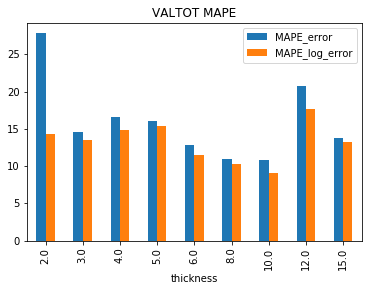

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,27.789607,14.314935,26
3.0,14.582327,13.552619,106
4.0,16.537992,14.784447,187
5.0,16.023061,15.345103,142
6.0,12.797082,11.495790,299
8.0,10.908986,10.331635,243
10.0,10.849415,9.063743,149
12.0,20.795548,17.589534,91


In [68]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

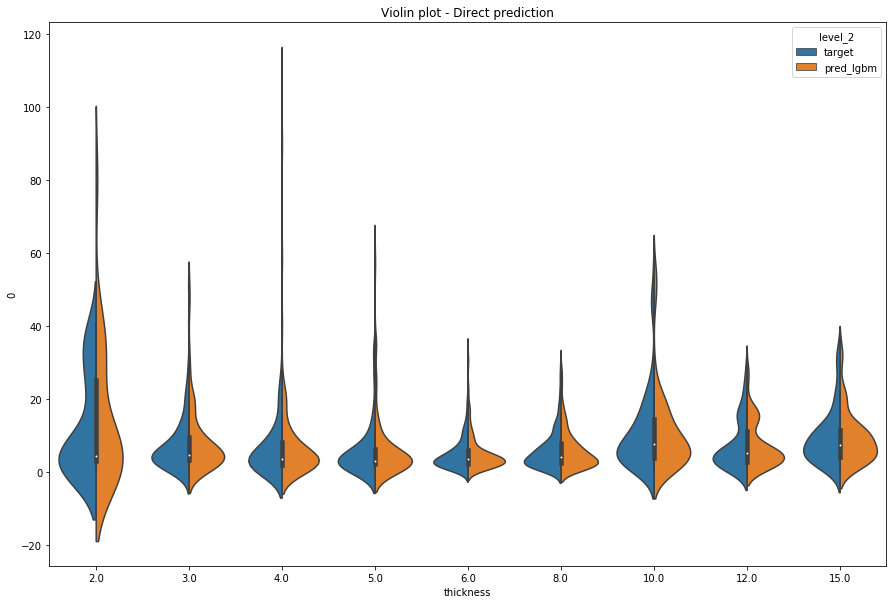

In [69]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - Direct prediction')
plt.show()

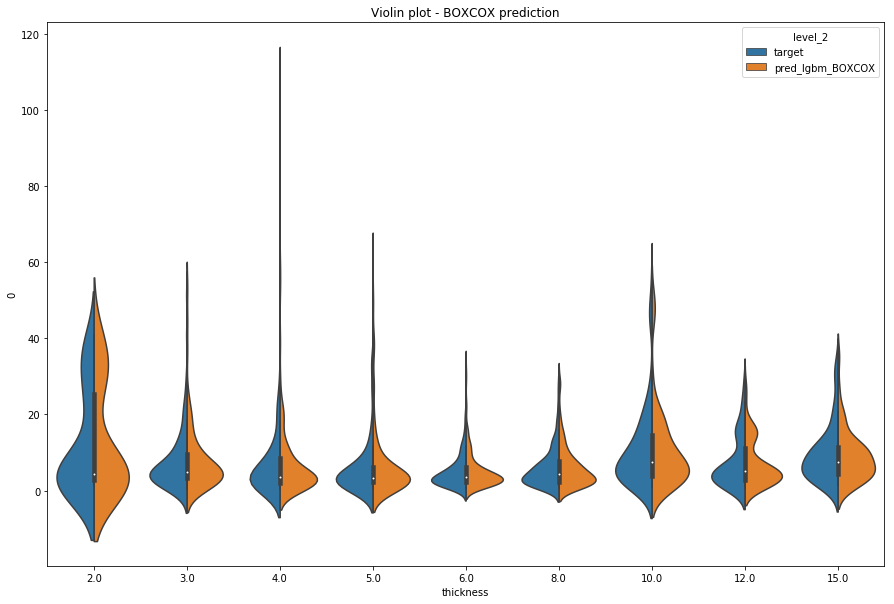

In [70]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm_BOXCOX', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - BOXCOX prediction')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


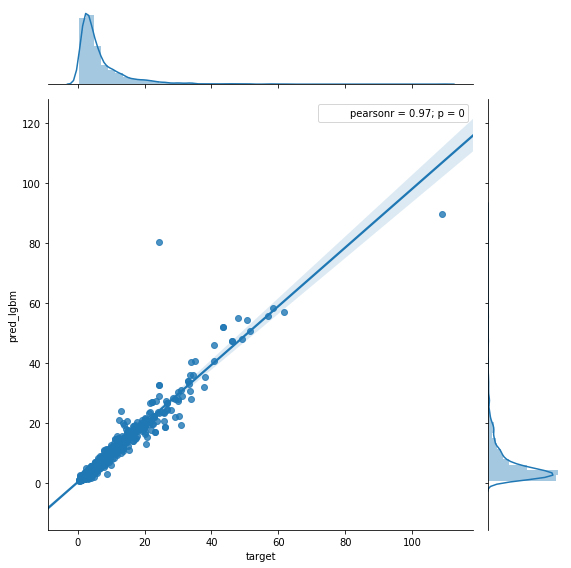

In [71]:
# No BOXCOX
sns.jointplot(x='target', y='pred_lgbm', data=comparisonset, kind='reg', size=8)
plt.show()

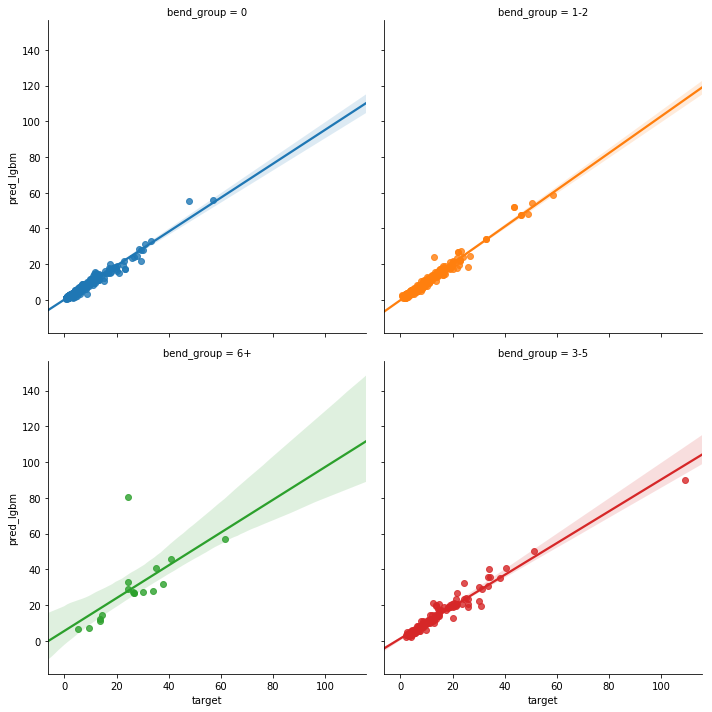

In [72]:
sns.lmplot(x='target',
           y='pred_lgbm',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


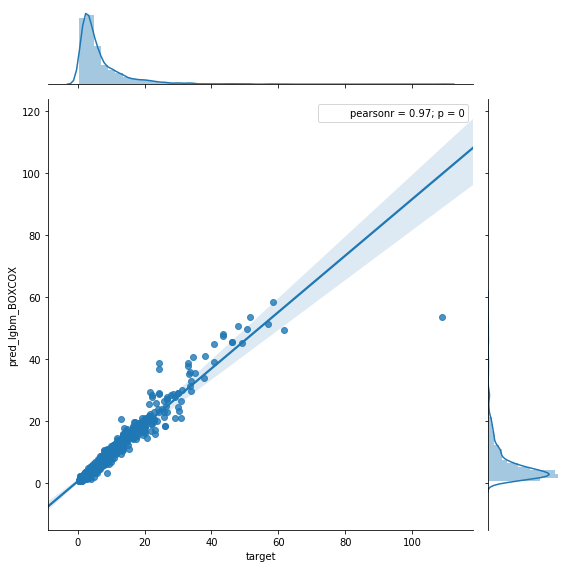

In [73]:
# With BOXCOX
sns.jointplot(x='target', y='pred_lgbm_BOXCOX', data=comparisonset, kind='reg',size=8)
plt.show()

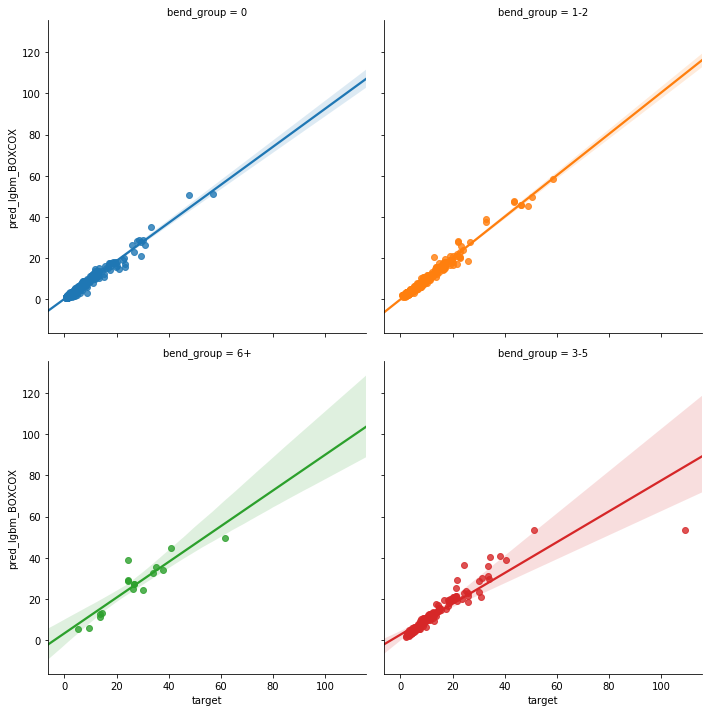

In [74]:
sns.lmplot(x='target',
           y='pred_lgbm_BOXCOX',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [75]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    3130.018997
           L5606430      70.892835
           L6012920      42.412547
           L5606410      34.885311
           L7001102      34.877738
3.0        L6015910      69.909779
           L8043340      38.970068
           L8416790      36.719364
           L8041050      32.220124
           L3111900      27.182161
4.0        L1608630     367.674999
           L6006670     137.187875
           L7066130      72.517976
           L6011860      56.607091
           L8808960      56.100381
5.0        L7018061     119.120037
           L3122540      20.270640
           L2608480      11.248048
           L6706240      10.080871
           L8051910       6.070293
6.0        L6000541      65.448533
           L8047680      10.746718
           L8816941       8.541392
           L6018950       7.764086
           L7022810       7.374102
8.0        L1614700      24.117199
           L1614680      23.196684
           L7056740      13.375387


In [76]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,218,280,396,567,676,874,1260,1284
COART,L2603300,L3108011,L6014840,L2509970,L2603290,L2520480,L2607650,L3108012
pred_lgbm,4.30409,7.98478,12.8127,7.51871,4.38668,11.4282,23.3779,8.04186
pred_lgbm_BOXCOX,4.6987,7.89199,13.0226,6.93097,4.74186,11.5146,22.9729,7.86845
target,5.45,8.7,13.32,7.1,5.45,11.84,25.8,6.72
MSE_lgbm,1.31311,0.511534,0.257344,0.17532,1.13065,0.169591,5.86646,1.74732
MSE_log_lgbm,0.564453,0.652876,0.0884395,0.0285721,0.501457,0.105916,7.99226,1.31893
cut_length,812.513,1105.28,1797.27,1323.45,812.511,1583.34,3137.92,1148.17
num_closed_patterns,3,7,3,4,3,6,3,8
num_open_patterns,0,0,0,0,0,0,0,0
total_area,16131,26965.1,89761.7,43451.9,16131,84344.4,113772,26845


In [77]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L8835850
cut_length,6989.19
num_closed_patterns,19
num_open_patterns,0
total_area,196112
minimum_rectangle_area,626653
minimum_rectangle_dim1,1322.67
minimum_rectangle_dim2,473.779
convex_hull_area,530068
no_hole_area,221461
thickness,8


# Summing solution :  
VALTOT = VAMAT + VALAJOUT

In [78]:
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm
COART,,,,,
L3104170,6.973162,6.977706,8.13,1.338274,1.327781
L8826140,2.499663,2.401807,2.42,0.006346,0.000331
L1615860,1.030293,0.822178,1.04,0.000094,0.047446
L8055440,4.188617,4.083776,4.55,0.130597,0.217365
L8042170,3.675951,3.580345,3.74,0.004102,0.025490


In [79]:
VAMAT = pd.read_csv('VAMAT_pred_lgbm.csv')
VAMAT.columns = ['COART', 'VAMAT_pred']
VALAJOUT = pd.read_csv('VALAJOUT_pred_lgbm.csv')
VALAJOUT.columns = ['COART', 'VALAJOUT_pred']
print(VAMAT.shape, VALAJOUT.shape)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

In [ ]:
sumset = pd.merge(resultset.reset_index(), VAMAT, on='COART', how='inner')
sumset = pd.merge(sumset, VALAJOUT, on='COART', how='inner')

sumset.shape

In [ ]:
sumset['VALTOT_sum'] = sumset['VAMAT_pred'] + sumset['VALAJOUT_pred']
sumset.head()

In [ ]:
mean_absolute_percentage_error(sumset['target'], sumset['VALTOT_sum'])

In [ ]:
mean_squared_error(sumset['target'], sumset['VALTOT_sum'])

In [ ]:
sns.jointplot(x='target', y='VALTOT_sum', data=sumset, kind='reg', size=8)

# Hyper Opt

In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

https://github.com/hyperopt/hyperopt/wiki/FMin

In [ ]:

scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(X_train[limitedset])
Xte_scaled = scaler.transform(X_test[limitedset])

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['num_leaves']),
        'min_split_gain': params['min_split_gain'],
        'reg_alpha': params['reg_alpha'],
        #'reg_lambda': params['reg_lambda'],
        'min_child_weight': int(params['min_child_weight']),
        'learning_rate':params['learning_rate'],
        
    }
    
    clf = lgb.LGBMRegressor(objective='regression',
        n_estimators=500,
        **params
    )
    
    score = cross_val_score(clf, Xtr_scaled, y_train[target], scoring='neg_mean_squared_error', cv=3).mean()
    print("MSE {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'max_depth': hp.uniform('max_depth', 1000, 1500),
    'min_split_gain': hp.uniform('min_split_gain', 0, 10),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    #'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'min_child_weight': hp.uniform('min_child_weight', 0, 20),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

In [ ]:
gbm = lgb.LGBMRegressor(objective='regression',
                        learning_rate=0.1,
                        n_estimators=500,
                        max_depth=1100,
                        lambda_l1=.4,
                        #lambda_l2=4.58,
                        colsample_bytree=0.06,
                        num_leaves=100,
                        min_split_gain=7,
                        min_child_weight=13,
                        random_state=0,
                       )
pipe = [('scaler', scaler), ('gbm', gbm)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])

In [ ]:
mean_squared_error(y_test[target], regpip.predict(X_test[limitedset]))

In [ ]:
mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))

In [ ]:
regpip.named_steps['gbm']